In [3]:
import numpy as np
import torch
from torch.distributions.multivariate_normal import MultivariateNormal

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import plotly
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

from skimage import io
import os

import math
import requests

from queue import PriorityQueue

In [4]:
plotly.__version__
pio.renderers.default = "iframe"

In [5]:
np.__version__

'1.24.3'

In [6]:
np.random.seed(0)

In [7]:
available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
available_gpus

In [9]:
%load_ext autoreload
%autoreload 2

from model import Bicycle, Map
from mppi import MPPI, MPPI_path_follower
from path_planner import a_star_planner
from sim import Simulation


import kmeans, gmm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
torch.cuda.empty_cache() 

In [11]:
# avoid = []

# rect = [(20, 0, 80, 50),(20,51,80, 100) ]
# circle= []

# state_dim = 3
# ctrl_dim = 2
# u_min = (0., -4.)
# u_max = (10., 4.)
# step = .05
# follow_depth = 16 # note: if these parameters are changed, the mppi ones should be changed to match
# horizon_depth = 64

#start at 1-5, 45-55, angle -0

In [12]:
# avoid = []

# rect = [(0, 0, 100, 10),(0, 0, 10, 100), (0, 61, 85, 100), (20, 0, 100, 59),(95,0,100,100) ]
# circle= [(20,40, 6), (10, 30, 6),(10, 50, 6)]

# state_dim = 3
# ctrl_dim = 2
# u_min = (0., -4.)
# u_max = (10., 4.)
# step = .05
# follow_depth = 16 # note: if these parameters are changed, the mppi ones should be changed to match
# horizon_depth = 64

# #start at (11-19, 11-19), angle math.pi/2

In [13]:
avoid = []

rect = [(0, 15, 47, 85), (53, 15, 100,85)]
left_circles = [(47,20+x, 4) for x in range(0, 80, 20)]
print(left_circles)
right_circles = [(53,30+x, 4) for x in range(0, 60, 20)]
circle= left_circles + right_circles

state_dim = 3
ctrl_dim = 2
u_min = (0., -4.)
u_max = (10., 4.)
step = .05
follow_depth = 16 # note: if these parameters are changed, the mppi ones should be changed to match
horizon_depth = 64

# start at (45-55, 1-5), angle math.pi/2
#goal at 50, 90

[(47, 20, 4), (47, 40, 4), (47, 60, 4), (47, 80, 4)]


In [14]:
def get_expert_controls(control_history, horizon_depth, ctrl_dim, interval_start = 0, interval_end = None, interval_step=2, dev="cpu"):
    if(interval_end is None):
        interval_end = len(control_history)-1
    first_rollout = interval_start
    last_rollout = interval_end-horizon_depth
    
    rollout_starts = range(first_rollout, last_rollout+1, interval_step)
    size = len(rollout_starts)
    
    expert_controls = torch.empty([size, horizon_depth, ctrl_dim], dtype = torch.float, device = dev)
    count = 0
    for i in rollout_starts:
        expert_controls[count,:,:] = torch.stack(control_history[i:i+horizon_depth])        
        count+=1
    return expert_controls

In [15]:
available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
print(r+a)
print(t, r, a)
torch.cuda.empty_cache() 

0
25426132992 0 0


In [ ]:
expert_controls = torch.tensor([],device = torch.device('cuda:0')) # used to reset expert_controls from constantly appending
a_star_sim = None
#
for i in range(3):
    for j in range(5):
        x = np.random.uniform(45, 55)
        y = np.random.uniform(1, 5)
        angle = np.random.uniform(5 *math.pi/12, 7*math.pi/12)

        if(angle<0):
            angle+=2 * math.pi
            
        a_star_robot = Bicycle(x, y, angle, 0)
        goal = (50, 90, 3, 10)

        mppi_sample_center= torch.tensor([0., 0.])
        mppi_sample_covariance = torch.tensor([[4.,0.],[0., 1]])

        env = Map(goal_point = goal, avoidance_points=avoid, rect_obstacles=rect,circle_obstacles=circle, device = torch.device('cuda:0'))
        a_star_map = Map(goal_point = (a_star_robot.x, a_star_robot.y,4,4), speed_weight = 0.1, avoidance_points=avoid, 
                         rect_obstacles=rect,circle_obstacles=circle, device = torch.device('cuda:0'))

        def a_star_heuristic(state):     
            return env.terminal_state_cost_batch(state)

        a_star_plan = a_star_planner(a_star_robot, state_dim, ctrl_dim, u_min, u_max, 
                          env.get_obstacles_batch, env.get_distance_batch,
                         iterations = 50000, goal_point = env.goal_point, angle_density = 32, grid_interval = 0.4, goal_tolerance =0.1, 
                                           timestep = step, device=torch.device('cuda:0'))
        
        print (i, j, x, y, "plan ready")
        a_star_follower = MPPI_path_follower(a_star_robot, state_dim, ctrl_dim, 
                          mppi_sample_center, mppi_sample_covariance,  u_min, u_max, 
                          a_star_robot.dynamics_batch_horizon, a_star_map, 
                                             a_star_map.running_cost_batch_horizon, a_star_map.terminal_state_cost_batch, a_star_plan.path, 
                         num_samples = 8192, horizon = follow_depth, lambda_=.1, sample_null_action = True,
                          timestep = step, device=torch.device('cuda:0'))
        print("expert demo started")
        
        a_star_sim = Simulation(a_star_robot, a_star_follower, a_star_map, goal_tolerance = 1, timestep = step)
        
        iter, goal_reached = a_star_sim.run(500, False, True, True, True, 
                                            write_rollout_start = 0, write_rollouts_num = 10, write_rate = 2)

        if not goal_reached:
            #a_star_sim.display_run()
            #a_star_sim.display_history()
            print("L")
        else:
            #a_star_sim.display_run()
            #a_star_sim.display_history()
            new_controls = get_expert_controls(a_star_robot.control_history, horizon_depth, ctrl_dim,interval_step = 2, dev = torch.device('cuda:0'))
            
            #expert_means, assigned_num, loss = kmeans.k_means_segment(new_controls, k = 7)
            expert_controls = torch.cat((expert_controls, new_controls), 0)
    
            #expert_means[:, :, -1] = -expert_means[:, :, -1]
            new_controls[:, :, -1] = -new_controls[:, :, -1]
            expert_controls = torch.cat((expert_controls, new_controls), 0)

        
        # losses = []
        # clusters = []
        
        # for num_cluster in range(1, 50, 5):
        #     expert_means, assigned_num, loss = kmeans.k_means_segment(new_controls, k = num_cluster)
        #     losses.append(loss)
        #     clusters.append(num_cluster)
        # plt.plot(clusters, losses)
        # plt.show()
            torch.cuda.empty_cache() 
            print(expert_controls.shape)



In [53]:
# a_star_sim.draw_explored(a_star_plan.path, False)

# a_star_sim.display_run()
# a_star_sim.display_history()

torch.cuda.empty_cache() 
gmm_means, gmm_cov, gmm_pi, ll = gmm.run_model(expert_controls, 10)

NameError: name 'X' is not defined

In [ ]:
%who

In [ ]:
losses = []
clusters = []

for num_cluster in range(1, 20):
    #expert_means, expert_covariances, loss = kmeans.k_means_segment(expert_controls, k = num_cluster)
    expert_means, loss = kmeans.k_means_segment(expert_controls, k = num_cluster)
    losses.append(loss)
    clusters.append(num_cluster)
    print(num_cluster)

[567183.375, 548189.375, 535722.0, 528013.6875, 521407.625, 516272.5, 512049.625, 509071.59375, 506636.40625, 504797.65625, 503273.78125, 502231.90625, 501351.59375, 500160.34375, 499211.125, 498247.0625, 497324.0, 496316.03125, 496112.5]


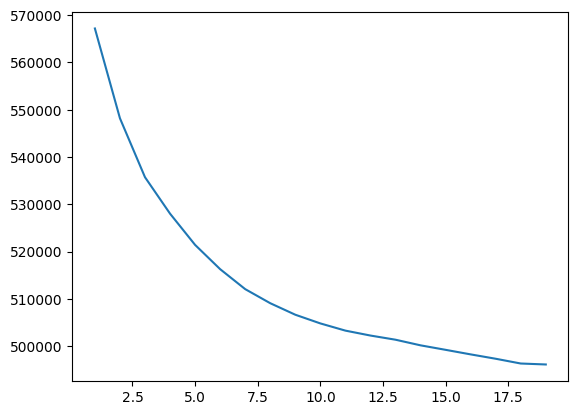

In [171]:
print(losses)
plt.plot(clusters, losses)
plt.show()

In [172]:
num_clusters = 10
expert_means, loss = kmeans.k_means_segment(expert_controls, k = num_clusters)
print(expert_means.shape)


torch.Size([10, 64, 2])


In [175]:
use_expert_controls = True
samples = 2048
controls = None

expert_samples = [50 for i in range(10)]

if use_expert_controls:
    if expert_samples is not None:
        samples = samples - sum(expert_samples)
        controls = expert_means
    else:
        samples = samples - expert_controls.shape[0]
        controls = expert_controls
    
if(samples <0):
    print("too many expert rollouts")

In [176]:

mppi_sample_center= torch.tensor([0., 0.])
mppi_sample_covariance = torch.tensor([[9.,0.],[0.,1]])
expert_sample_center= torch.zeros(ctrl_dim *horizon_depth)
expert_sample_covariance = torch.tensor([[.09,0.],[0., .01]])
# note: if these parameters are changed, the a-star ones should be changed to match

# changes to 8 clusters

success = 0.
total = 0.
total_it = 0.

for i in range(10):
    for j in range(10):
        x = np.random.uniform(45, 55)
        y = np.random.uniform(1, 5)
        angle = np.random.uniform(5 *math.pi/12, 7*math.pi/12)

        if(angle<0):
            angle+=2 * math.pi

        mppi_robot = Bicycle(x, y, angle, 0)
        mppi_goal = (50, 90, 1, 10)


        mppi_map = Map(goal_point = mppi_goal, avoidance_points=avoid, 
                       rect_obstacles=rect,circle_obstacles=circle, speed_weight = 0.01, device = torch.device('cuda:0'))
        mppi_controller = MPPI(mppi_robot, state_dim, ctrl_dim, 
                          mppi_sample_center, mppi_sample_covariance,  u_min, u_max,
                          mppi_robot.dynamics_batch_horizon, mppi_map.running_cost_batch_horizon, mppi_map.terminal_state_cost_batch,
                               expert_rollouts = controls, expert_samples = expert_samples, 
                               expert_mu = mppi_sample_center, expert_noise = expert_sample_covariance,
                               num_samples = samples, horizon = horizon_depth, lambda_=1,sample_null_action = True,
                               timestep = step, device=torch.device('cuda:0'))
        mppi_sim = Simulation(mppi_robot, mppi_controller, mppi_map, timestep = step, goal_tolerance = 2)

        iterations, completed = mppi_sim.run(iterations=400, draw_obstacles = False, write_snapshots =False, 
              write_rollouts=True, write_controls = True, write_rollout_start = 0, write_rollouts_num = 6,write_rate = 2)
        
        

        if completed:
            success+=1
            total_it += iterations
        else:
            mppi_sim.display_history()
        total+=1
        
        
        print(i, j, completed, iterations, success/total)
        
print(success/total)
if success > 0:
    print(total_it/success)



0 0 True 201 1.0
0 1 True 211 1.0
0 2 True 214 1.0
0 3 True 204 1.0


0 4 False 58 0.8
0 5 True 207 0.8333333333333334
0 6 True 210 0.8571428571428571
0 7 True 226 0.875
0 8 True 206 0.8888888888888888
0 9 True 212 0.9
1 0 True 201 0.9090909090909091
1 1 True 209 0.9166666666666666
1 2 True 210 0.9230769230769231
1 3 True 207 0.9285714285714286
1 4 True 213 0.9333333333333333
1 5 True 213 0.9375
1 6 True 205 0.9411764705882353
1 7 True 210 0.9444444444444444
1 8 True 214 0.9473684210526315
1 9 True 214 0.95
2 0 True 208 0.9523809523809523
2 1 True 208 0.9545454545454546
2 2 True 217 0.9565217391304348
2 3 True 214 0.9583333333333334
2 4 True 220 0.96
2 5 True 206 0.9615384615384616
2 6 True 214 0.9629629629629629
2 7 True 219 0.9642857142857143


2 8 False 104 0.9310344827586207
2 9 True 226 0.9333333333333333
3 0 True 211 0.9354838709677419
3 1 True 223 0.9375
3 2 True 217 0.9393939393939394
3 3 True 213 0.9411764705882353
3 4 True 208 0.9428571428571428


3 5 False 182 0.9166666666666666
3 6 True 214 0.918918918918919
3 7 True 211 0.9210526315789473
3 8 True 214 0.9230769230769231
3 9 True 212 0.925
4 0 True 209 0.926829268292683
4 1 True 202 0.9285714285714286
4 2 True 209 0.9302325581395349
4 3 True 206 0.9318181818181818
4 4 True 210 0.9333333333333333
4 5 True 219 0.9347826086956522


4 6 False 40 0.9148936170212766
4 7 True 214 0.9166666666666666
4 8 True 216 0.9183673469387755
4 9 True 204 0.92
5 0 True 215 0.9215686274509803
5 1 True 210 0.9230769230769231
5 2 True 212 0.9245283018867925
5 3 True 202 0.9259259259259259
5 4 True 220 0.9272727272727272
5 5 True 215 0.9285714285714286
5 6 True 211 0.9298245614035088
5 7 True 208 0.9310344827586207


5 8 False 63 0.9152542372881356
5 9 True 204 0.9166666666666666


6 0 False 64 0.9016393442622951


6 1 False 127 0.8870967741935484
6 2 True 207 0.8888888888888888
6 3 True 218 0.890625
6 4 True 209 0.8923076923076924
6 5 True 220 0.8939393939393939
6 6 True 223 0.8955223880597015
6 7 True 204 0.8970588235294118
6 8 True 220 0.8985507246376812


6 9 False 61 0.8857142857142857
7 0 True 216 0.8873239436619719
7 1 True 213 0.8888888888888888
7 2 True 210 0.8904109589041096
7 3 True 221 0.8918918918918919
7 4 True 220 0.8933333333333333
7 5 True 208 0.8947368421052632


7 6 False 154 0.8831168831168831
7 7 True 216 0.8846153846153846
7 8 True 205 0.8860759493670886
7 9 True 210 0.8875


8 0 False 60 0.8765432098765432


8 1 False 81 0.8658536585365854


8 2 False 39 0.8554216867469879
8 3 True 215 0.8571428571428571


8 4 False 110 0.8470588235294118
8 5 True 201 0.8488372093023255
8 6 True 211 0.8505747126436781


8 7 False 43 0.8409090909090909
8 8 True 208 0.8426966292134831
8 9 True 214 0.8444444444444444
9 0 True 207 0.8461538461538461
9 1 True 206 0.8478260869565217
9 2 True 217 0.8494623655913979


9 3 False 173 0.8404255319148937
9 4 True 205 0.8421052631578947
9 5 True 207 0.84375
9 6 True 212 0.845360824742268
9 7 True 207 0.8469387755102041


9 8 False 152 0.8383838383838383


9 9 False 176 0.83
0.83
211.5421686746988
